/usr/local/lib/python3.10/dist-packages/scipy/signal/_signaltools.py:1659: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/usr/local/lib/python3.10/dist-packages/scipy/signal/_signaltools.py:1659: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
<ipython-input-1-6ee800623826>:32: RuntimeWarning: invalid value encountered in cast
  return np.uint8(wiener(img, (kernel_size, kernel_size, 1)))


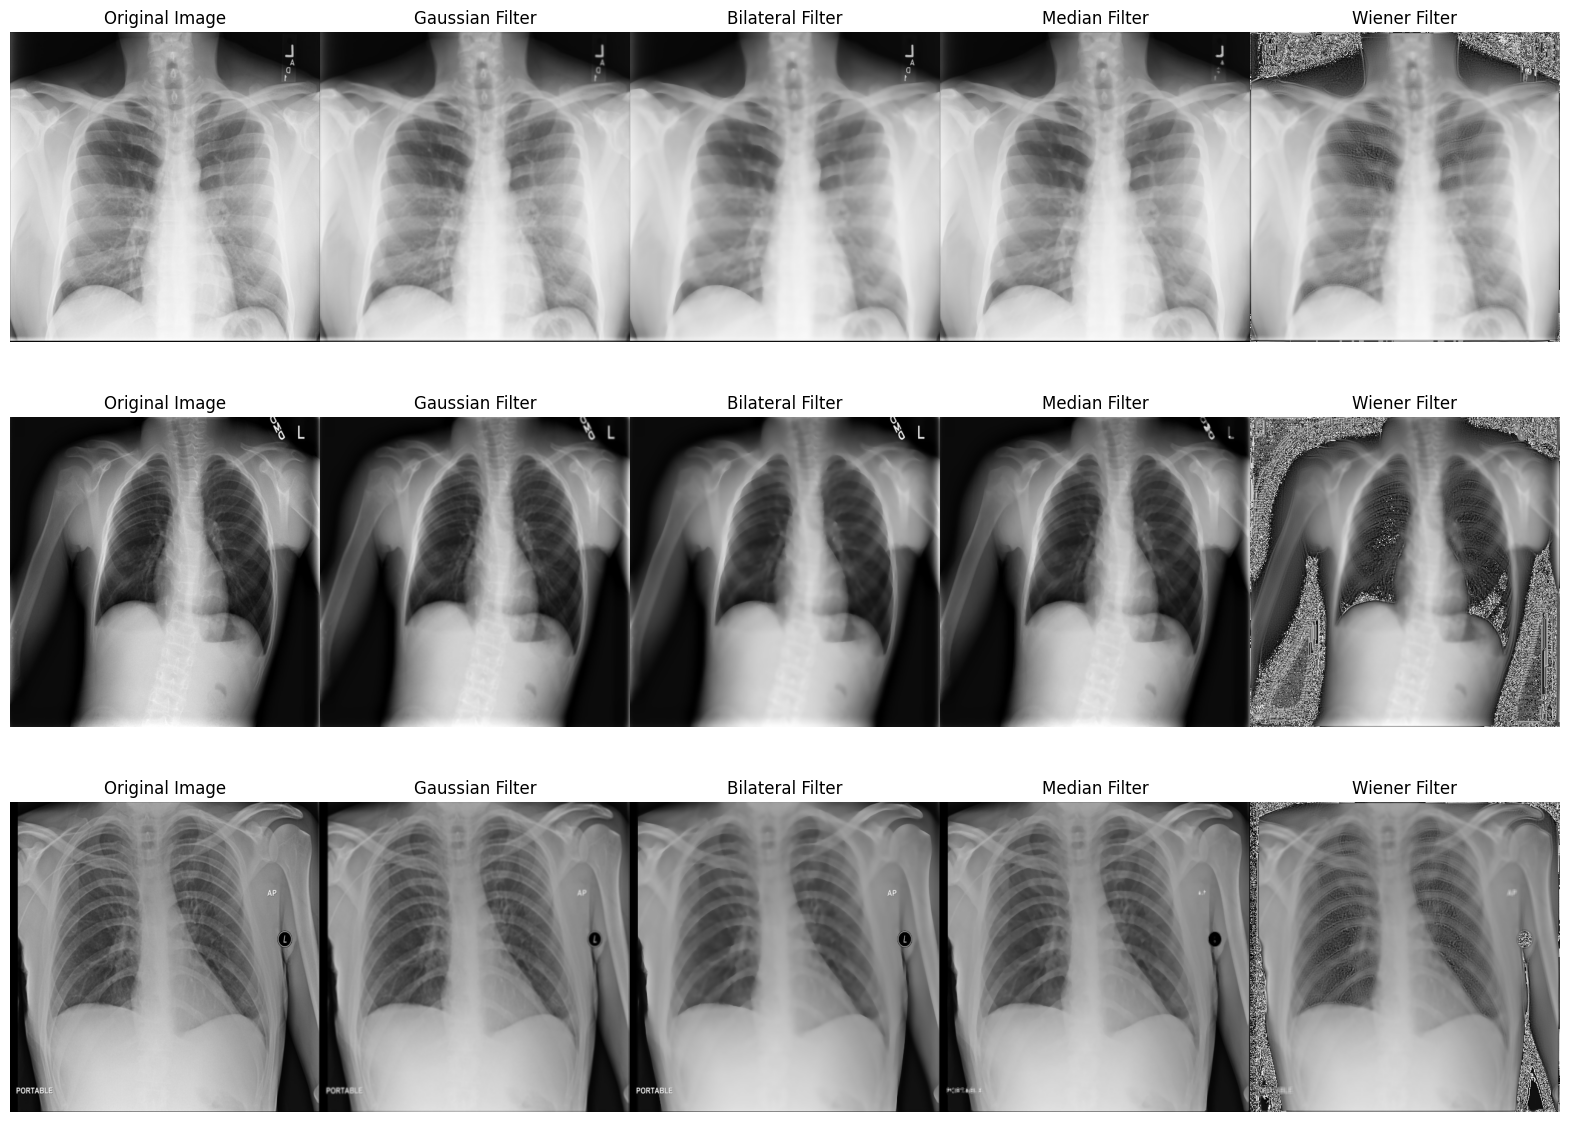

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# Define the path to the dataset folder
dataset_path = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal"  # Change this to your actual dataset path

# List images in the dataset (assuming it's a folder of images)
image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Select 3 random images
random_images = random.sample(image_files, 3)

def apply_filters(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Apply Gaussian filtering (linear filter)
    gaussian_filtered = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Apply Bilateral filtering (non-linear filter)
    bilateral_filtered = cv2.bilateralFilter(image, 9, 75, 75)
    
    # Apply Median filtering (non-linear filter)
    median_filtered = cv2.medianBlur(image, 5)
    
    # Apply Wiener filtering (adaptive filter)
    def wiener_filter(img, kernel_size=5):
        from scipy.signal import wiener
        return np.uint8(wiener(img, (kernel_size, kernel_size, 1)))
    wiener_filtered = wiener_filter(image)
    
    return image, gaussian_filtered, bilateral_filtered, median_filtered, wiener_filtered

# Process and display results for 3 images
fig, axs = plt.subplots(3, 5, figsize=(20, 15))
plt.subplots_adjust(wspace=0, hspace=0)  # Remove white spaces between images

for i, img_file in enumerate(random_images):
    image_path = os.path.join(dataset_path, img_file)
    image, gaussian_filtered, bilateral_filtered, median_filtered, wiener_filtered = apply_filters(image_path)
    
    axs[i, 0].imshow(image)
    axs[i, 0].set_title("Original Image")
    axs[i, 0].axis("off")
    
    axs[i, 1].imshow(gaussian_filtered)
    axs[i, 1].set_title("Gaussian Filter")
    axs[i, 1].axis("off")
    
    axs[i, 2].imshow(bilateral_filtered)
    axs[i, 2].set_title("Bilateral Filter")
    axs[i, 2].axis("off")
    
    axs[i, 3].imshow(median_filtered)
    axs[i, 3].set_title("Median Filter")
    axs[i, 3].axis("off")
    
    axs[i, 4].imshow(wiener_filtered)
    axs[i, 4].set_title("Wiener Filter")
    axs[i, 4].axis("off")

plt.show()

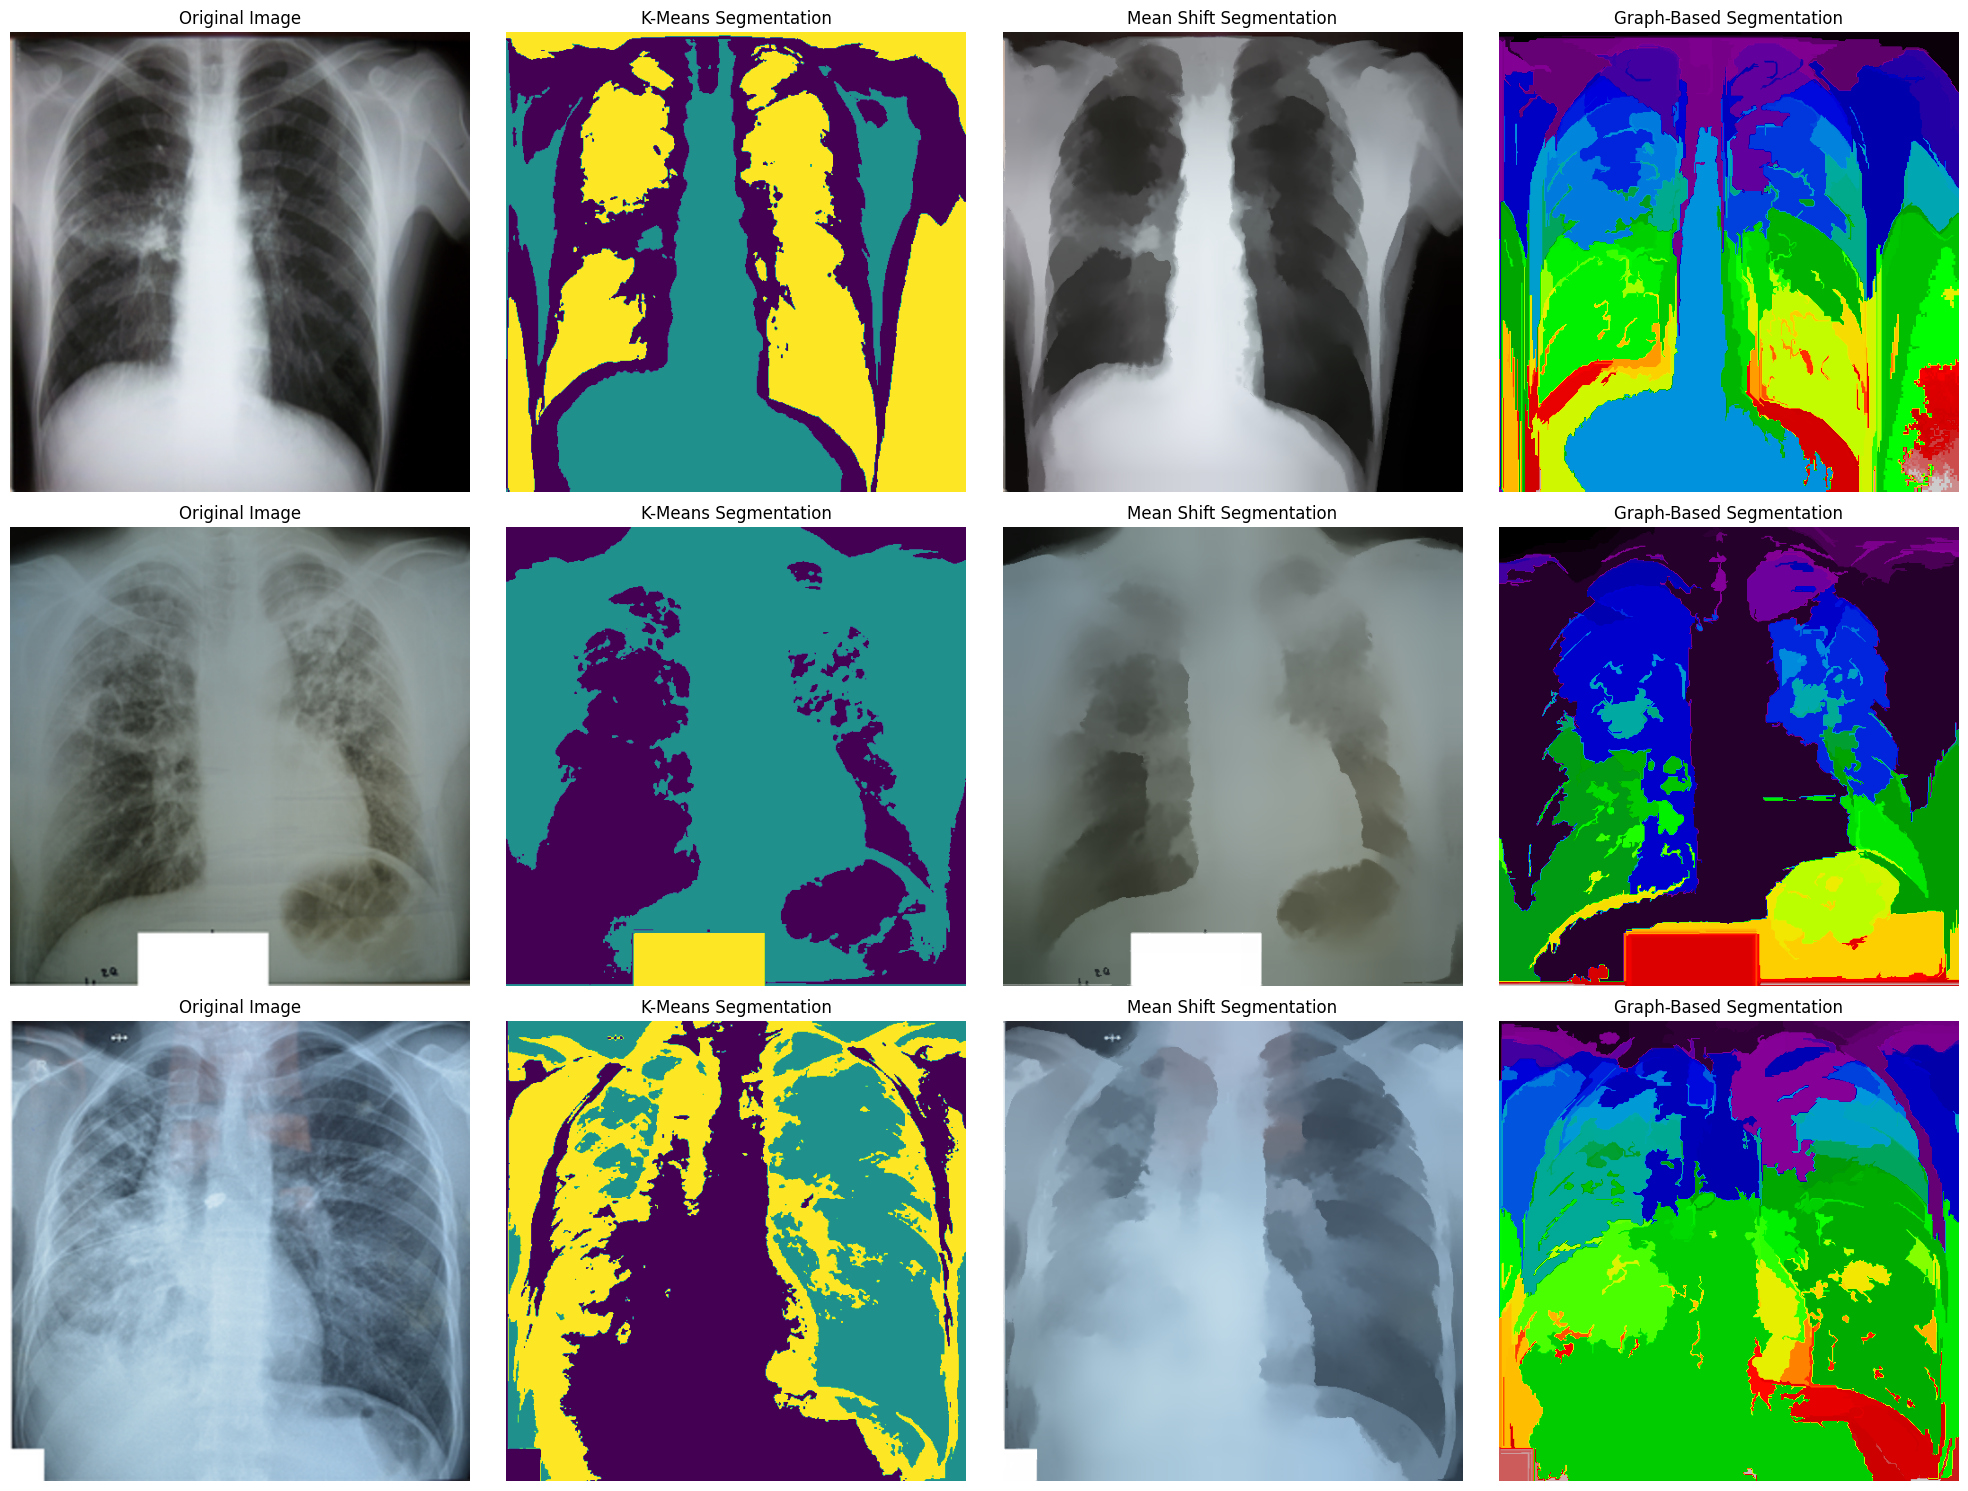

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from skimage.segmentation import felzenszwalb
from sklearn.cluster import KMeans
from skimage.color import rgb2gray
from skimage.filters import gaussian

# Define dataset path
dataset_path = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis"  # Change this to your dataset path

# Get list of image files
image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Select 3 random images
random_images = random.sample(image_files, 3)

# Function to apply segmentation techniques
def segment_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # ------------------- K-Means Segmentation -------------------
    def kmeans_segmentation(image, k=3):
        img_reshaped = image.reshape((-1, 3))
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(img_reshaped)
        segmented_img = labels.reshape(image.shape[:2])
        return segmented_img

    kmeans_segmented = kmeans_segmentation(image, k=3)

    # ------------------- Mean Shift Segmentation -------------------
    def mean_shift_segmentation(image):
        return cv2.pyrMeanShiftFiltering(image, 20, 40)

    mean_shift_segmented = mean_shift_segmentation(image)

    # ------------------- Graph-Based Segmentation -------------------
    def graph_based_segmentation(image):
        return felzenszwalb(image, scale=100, sigma=0.5, min_size=50)

    graph_segmented = graph_based_segmentation(image)

    return image, kmeans_segmented, mean_shift_segmented, graph_segmented

# Plot results: 3 rows (one per image), 3 columns (one per segmentation method)
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

for i, img_file in enumerate(random_images):
    image_path = os.path.join(dataset_path, img_file)
    image, kmeans_segmented, mean_shift_segmented, graph_segmented = segment_image(image_path)

    axs[i, 0].imshow(image)
    axs[i, 0].set_title("Original Image")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(kmeans_segmented, cmap="viridis")
    axs[i, 1].set_title("K-Means Segmentation")
    axs[i, 1].axis("off")

    axs[i, 2].imshow(mean_shift_segmented)
    axs[i, 2].set_title("Mean Shift Segmentation")
    axs[i, 2].axis("off")

    axs[i, 3].imshow(graph_segmented, cmap="nipy_spectral")
    axs[i, 3].set_title("Graph-Based Segmentation")
    axs[i, 3].axis("off")

plt.tight_layout()
plt.show()


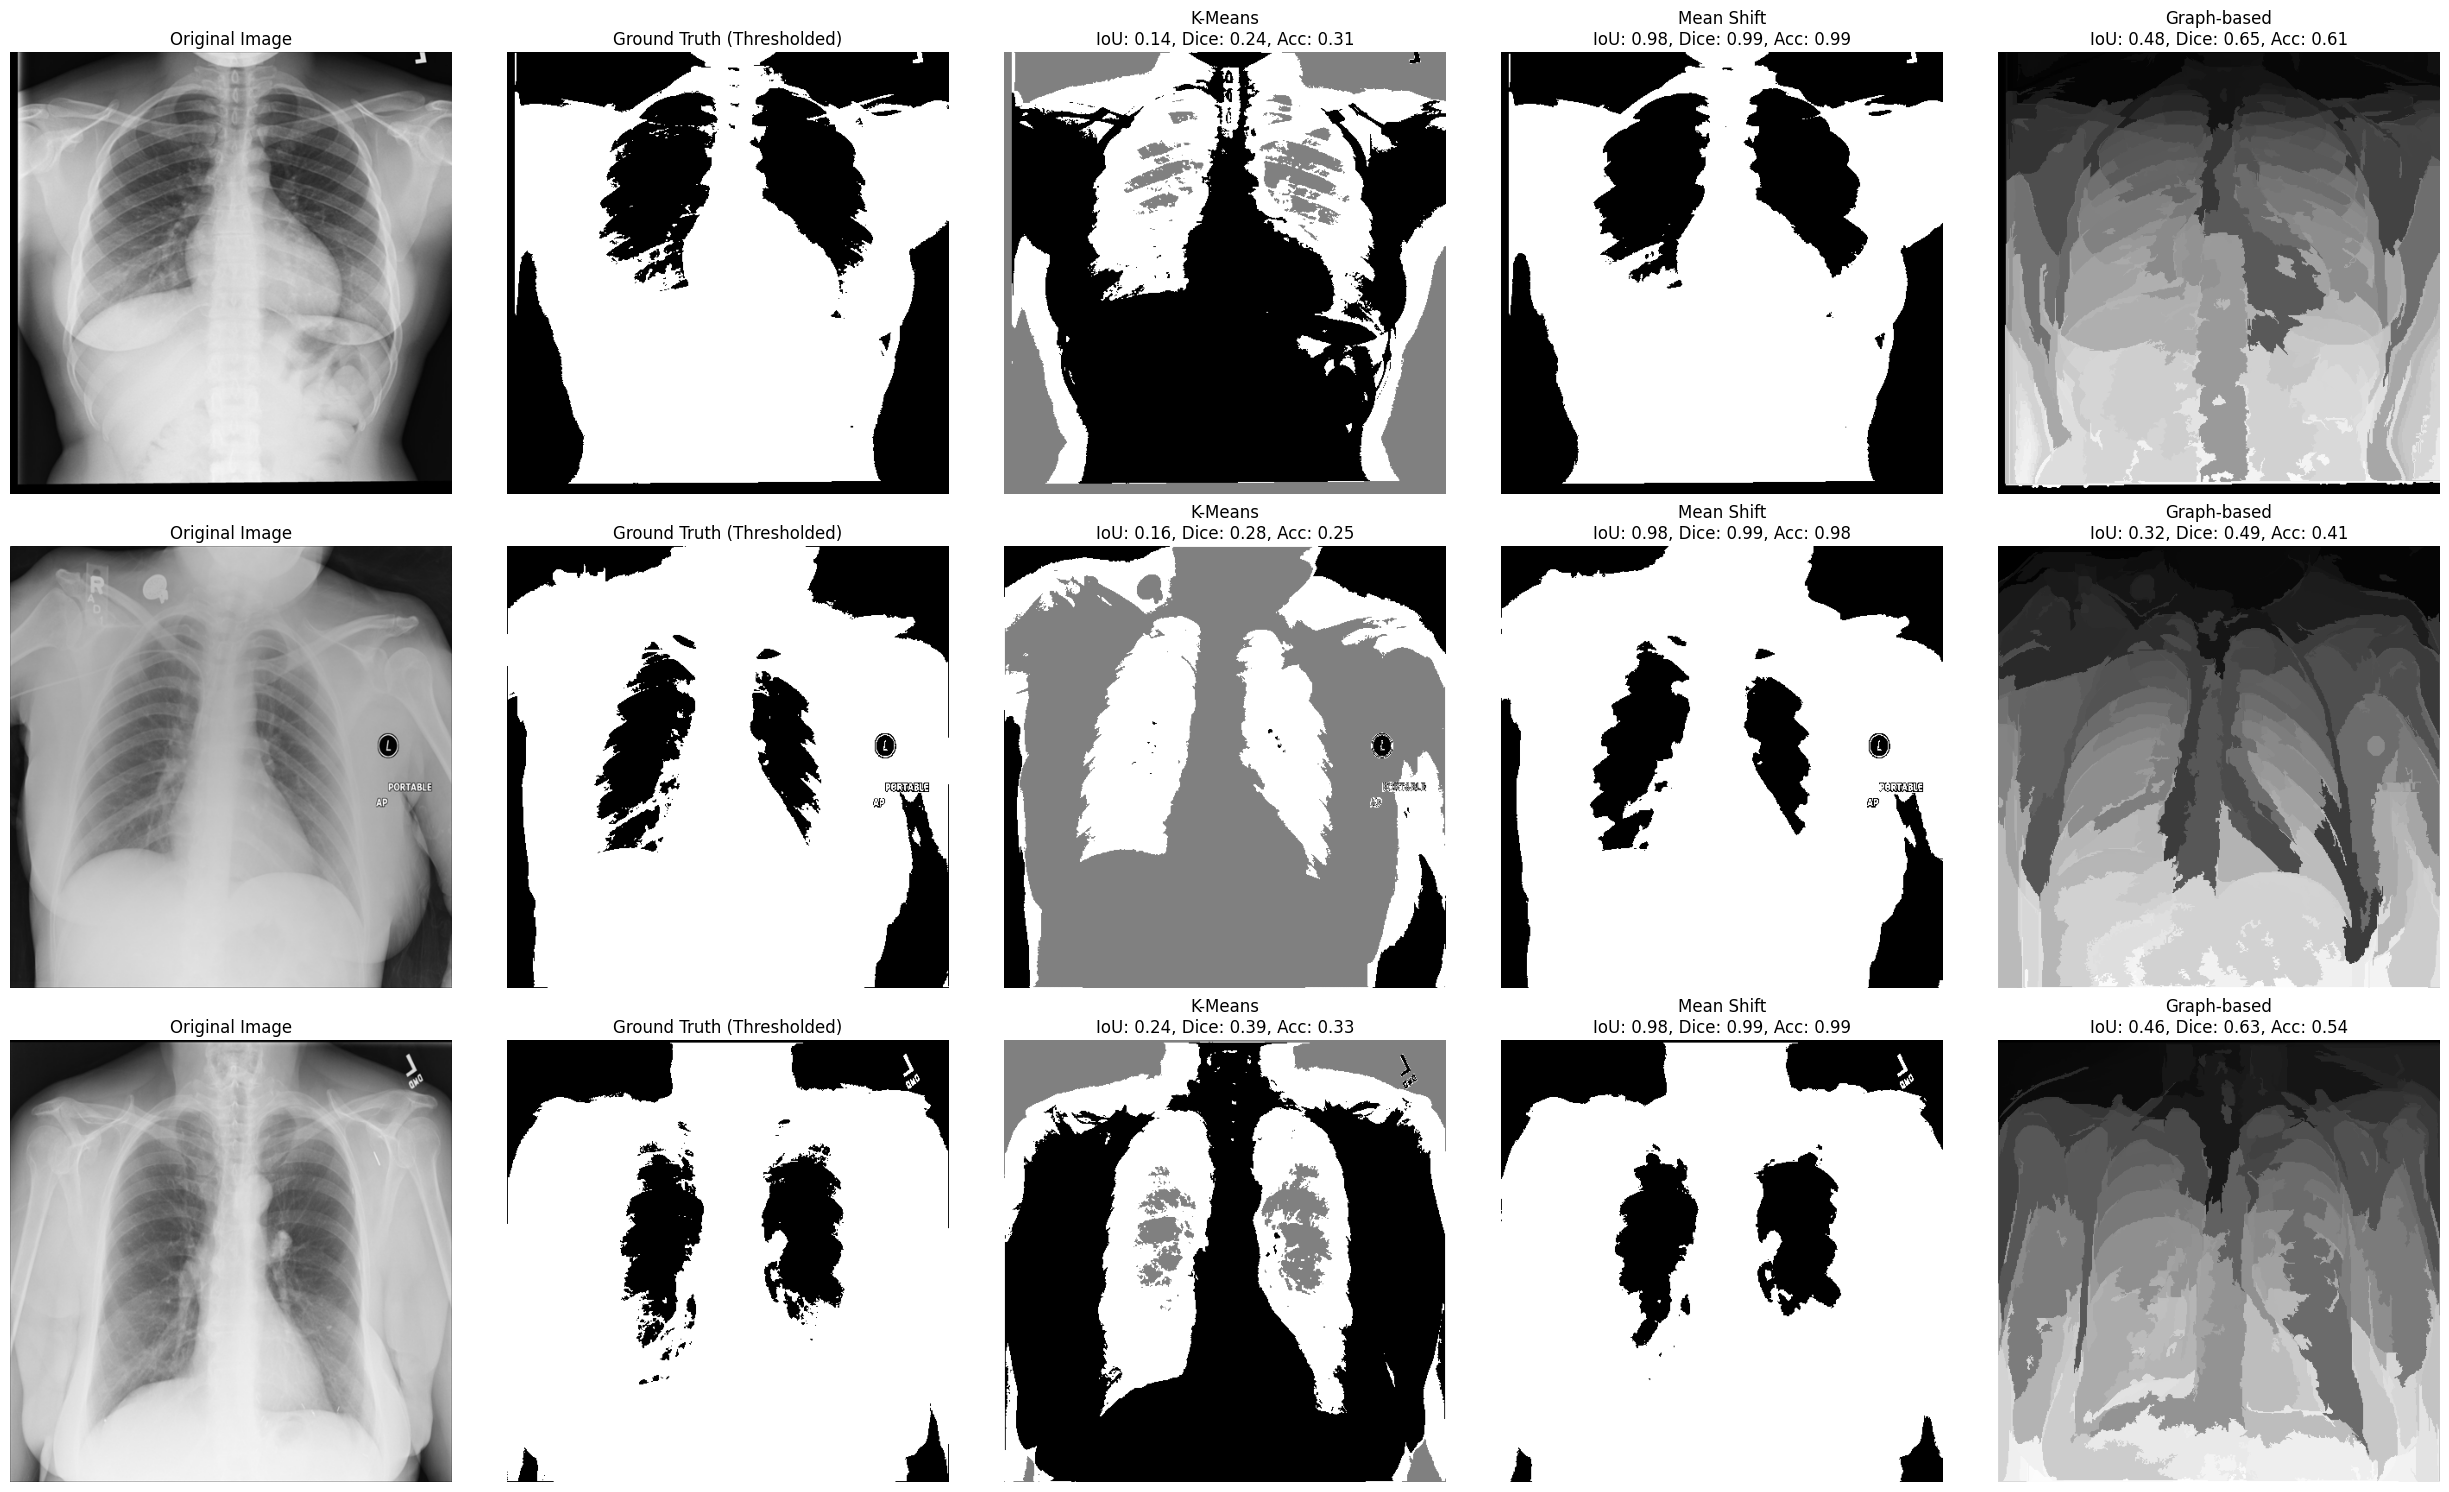

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.metrics import jaccard_score, f1_score, accuracy_score
from skimage.segmentation import felzenszwalb

# Define dataset path
dataset_path = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal"  # Update this to your dataset path

# List images in dataset
image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Select 3 random images
random_images = random.sample(image_files, 3)

# Function to apply segmentation methods
def apply_segmentation(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    
    # Convert to grayscale for thresholding (Simulated Ground Truth)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, ground_truth = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

    # --- K-Means Segmentation ---
    reshaped_img = image.reshape((-1, 3)).astype(np.float32)
    k = 3  # Number of clusters
    _, labels, _ = cv2.kmeans(reshaped_img, k, None, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0), 10, cv2.KMEANS_RANDOM_CENTERS)
    kmeans_result = labels.reshape(image.shape[:2])

    # Normalize to [0, 255] for thresholding
    kmeans_result = cv2.normalize(kmeans_result, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # --- Mean Shift Segmentation ---
    spatial_radius = 10
    color_radius = 20
    mean_shift_result = cv2.pyrMeanShiftFiltering(image, spatial_radius, color_radius)
    mean_shift_gray = cv2.cvtColor(mean_shift_result, cv2.COLOR_RGB2GRAY)
    _, mean_shift_result = cv2.threshold(mean_shift_gray, 128, 255, cv2.THRESH_BINARY)

    # --- Graph-based Segmentation (Felzenszwalb) ---
    graph_result = felzenszwalb(image, scale=100, sigma=0.5, min_size=50)

    # Convert graph segmentation to grayscale
    graph_result = cv2.normalize(graph_result, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    return image, ground_truth, kmeans_result, mean_shift_result, graph_result

# Function to compute IoU, Dice Score, and Pixel Accuracy
def evaluate_segmentation(ground_truth, segmented):
    # Ensure binary values (0,1)
    _, ground_truth = cv2.threshold(ground_truth, 128, 1, cv2.THRESH_BINARY)
    _, segmented = cv2.threshold(segmented, 128, 1, cv2.THRESH_BINARY)

    ground_truth_flat = ground_truth.flatten()
    segmented_flat = segmented.flatten()

    iou = jaccard_score(ground_truth_flat, segmented_flat, average='binary', zero_division=1)
    dice = f1_score(ground_truth_flat, segmented_flat, average='binary')
    pixel_acc = accuracy_score(ground_truth_flat, segmented_flat)

    return iou, dice, pixel_acc

# Plot results for each segmentation method
fig, axs = plt.subplots(3, 5, figsize=(25, 15))  # 5 columns: Original, GT, K-Means, Mean Shift, Graph-Based

for i, img_file in enumerate(random_images):
    image_path = os.path.join(dataset_path, img_file)
    original_image, ground_truth, kmeans_result, mean_shift_result, graph_result = apply_segmentation(image_path)

    # Compute evaluation metrics
    kmeans_iou, kmeans_dice, kmeans_acc = evaluate_segmentation(ground_truth, kmeans_result)
    mean_shift_iou, mean_shift_dice, mean_shift_acc = evaluate_segmentation(ground_truth, mean_shift_result)
    graph_iou, graph_dice, graph_acc = evaluate_segmentation(ground_truth, graph_result)

    # Display images row-wise
    axs[i, 0].imshow(original_image)
    axs[i, 0].set_title("Original Image")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(ground_truth, cmap='gray')
    axs[i, 1].set_title("Ground Truth (Thresholded)")
    axs[i, 1].axis("off")

    axs[i, 2].imshow(kmeans_result, cmap='gray')
    axs[i, 2].set_title(f"K-Means\nIoU: {kmeans_iou:.2f}, Dice: {kmeans_dice:.2f}, Acc: {kmeans_acc:.2f}")
    axs[i, 2].axis("off")

    axs[i, 3].imshow(mean_shift_result, cmap='gray')
    axs[i, 3].set_title(f"Mean Shift\nIoU: {mean_shift_iou:.2f}, Dice: {mean_shift_dice:.2f}, Acc: {mean_shift_acc:.2f}")
    axs[i, 3].axis("off")

    axs[i, 4].imshow(graph_result, cmap='gray')
    axs[i, 4].set_title(f"Graph-based\nIoU: {graph_iou:.2f}, Dice: {graph_dice:.2f}, Acc: {graph_acc:.2f}")
    axs[i, 4].axis("off")

plt.tight_layout()
plt.show()


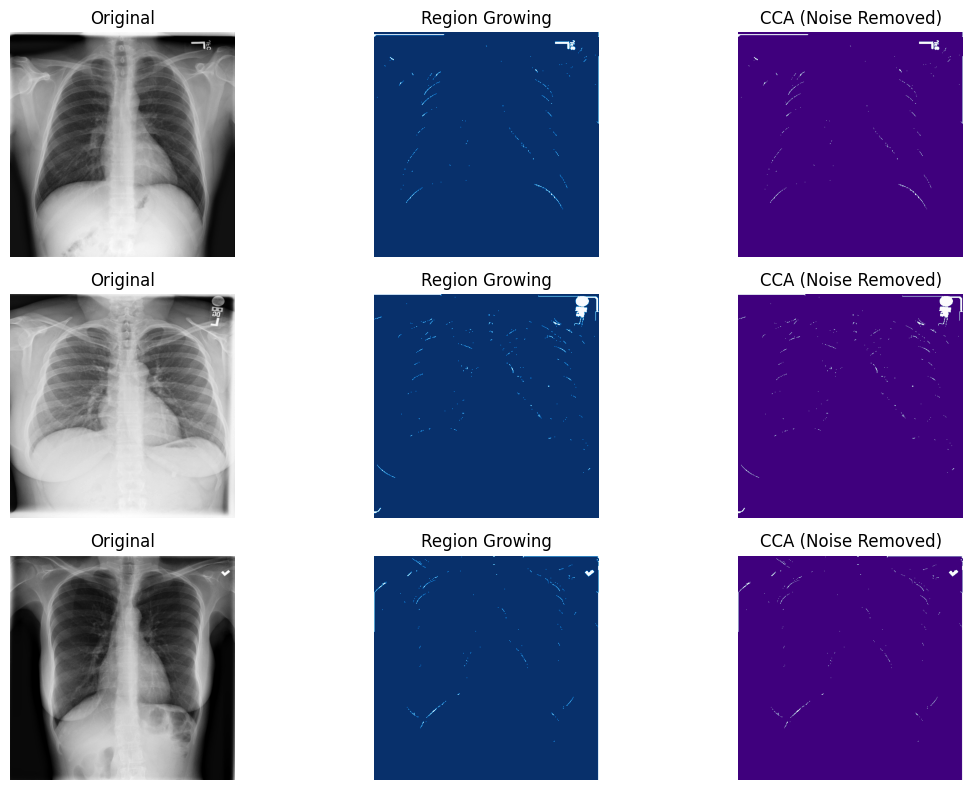

In [27]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from scipy.ndimage import label

# ✅ Define dataset path
dataset_path = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal"

# ✅ Function for Region Growing
def region_growing(image, seed):
    visited = np.zeros_like(image, dtype=bool)
    output = np.zeros_like(image, dtype=np.uint8)
    stack = [seed]
    threshold = 10  # Reduced threshold for better segmentation

    while stack:
        x, y = stack.pop()
        if not visited[x, y]:
            visited[x, y] = True
            output[x, y] = 255
            for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
                nx, ny = x+dx, y+dy
                if 0 <= nx < image.shape[0] and 0 <= ny < image.shape[1]:
                    if not visited[nx, ny] and abs(int(image[nx, ny]) - int(image[x, y])) < threshold:
                        stack.append((nx, ny))
    
    return output

# ✅ Function for Connected Component Analysis (CCA)
def connected_component_analysis(image):
    binary = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)[1]
    labeled_array, num_features = label(binary)
    
    # Normalize for better visualization
    if num_features > 0:
        labeled_array = (labeled_array / num_features) * 255
        labeled_array = labeled_array.astype(np.uint8)
    
    return labeled_array

# ✅ Select 3 random images from dataset
random_images = random.sample(os.listdir(dataset_path), 3)

# ✅ Plot images with region-based processing
fig, axs = plt.subplots(len(random_images), 3, figsize=(12, 8))

for i, img_file in enumerate(random_images):
    image_path = os.path.join(dataset_path, img_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # 🔥 **Better Seed Selection** (Find brightest region near lungs)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(image)
    seed = max_loc  # Using the brightest region as seed

    # Apply Region Growing & CCA
    region_growing_result = region_growing(image, seed)
    cca_result = connected_component_analysis(region_growing_result)

    # 🖼️ Show Results with New Colors
    axs[i, 0].imshow(image, cmap='gray')
    axs[i, 0].set_title("Original")

    axs[i, 1].imshow(region_growing_result, cmap='Blues')  # 🔵 Blue for Region Growing
    axs[i, 1].set_title("Region Growing")

    axs[i, 2].imshow(cca_result, cmap='Purples')  # 🟣 Purple for CCA
    axs[i, 2].set_title("CCA (Noise Removed)")

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()


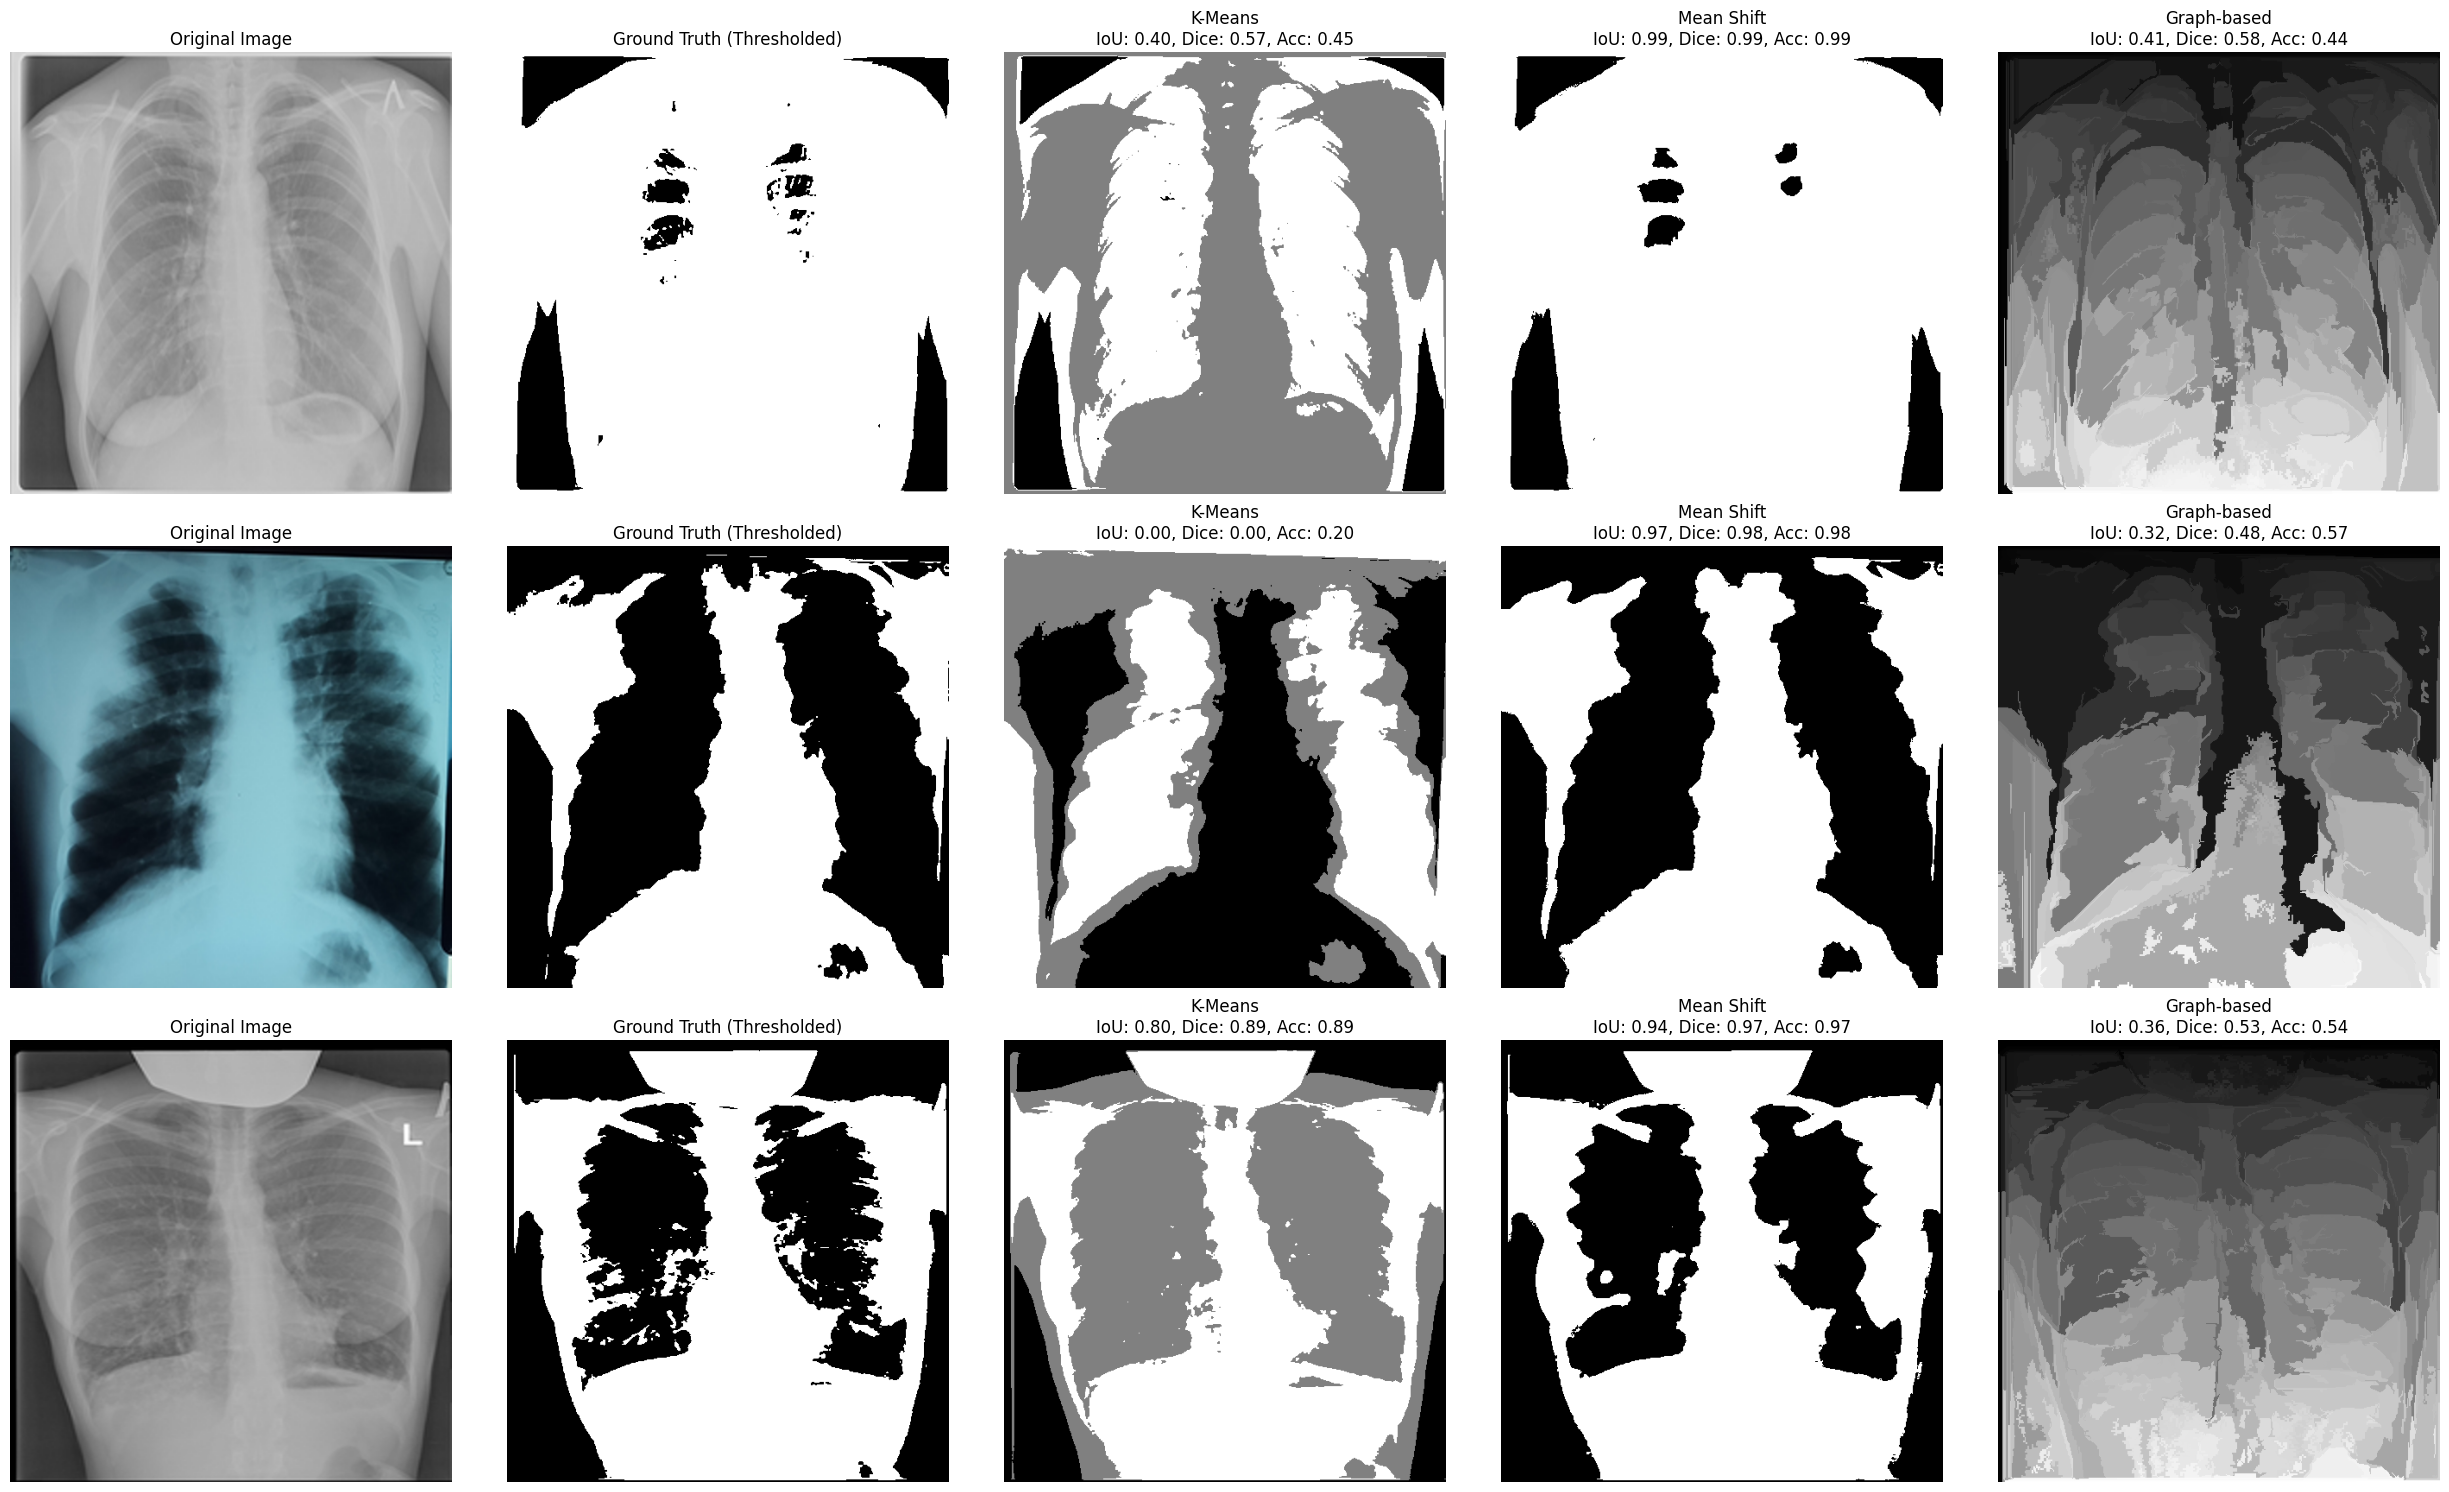


🏆 Segmentation Method Performance 🏆
K-Means:
  - Average IoU: 0.40
  - Average Dice Score: 0.48
  - Average Pixel Accuracy: 0.51
----------------------------------------
Mean Shift:
  - Average IoU: 0.96
  - Average Dice Score: 0.98
  - Average Pixel Accuracy: 0.98
----------------------------------------
Graph-based:
  - Average IoU: 0.36
  - Average Dice Score: 0.53
  - Average Pixel Accuracy: 0.52
----------------------------------------

🥇 Best Performing Segmentation Method: Mean Shift (Based on IoU) 🥇


In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.metrics import jaccard_score, f1_score, accuracy_score
from skimage.segmentation import felzenszwalb

# Define dataset path
dataset_path = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis"  # Update this to your dataset path

# List images in dataset
image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Select 3 random images
random_images = random.sample(image_files, 3)

# Function to apply segmentation methods
def apply_segmentation(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    
    # Convert to grayscale for thresholding (Simulated Ground Truth)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, ground_truth = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

    # --- K-Means Segmentation ---
    reshaped_img = image.reshape((-1, 3)).astype(np.float32)
    k = 3  # Number of clusters
    _, labels, _ = cv2.kmeans(reshaped_img, k, None, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0), 10, cv2.KMEANS_RANDOM_CENTERS)
    kmeans_result = labels.reshape(image.shape[:2])

    # Normalize to [0, 255] for thresholding
    kmeans_result = cv2.normalize(kmeans_result, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # --- Mean Shift Segmentation ---
    spatial_radius = 10
    color_radius = 20
    mean_shift_result = cv2.pyrMeanShiftFiltering(image, spatial_radius, color_radius)
    mean_shift_gray = cv2.cvtColor(mean_shift_result, cv2.COLOR_RGB2GRAY)
    _, mean_shift_result = cv2.threshold(mean_shift_gray, 128, 255, cv2.THRESH_BINARY)

    # --- Graph-based Segmentation (Felzenszwalb) ---
    graph_result = felzenszwalb(image, scale=100, sigma=0.5, min_size=50)

    # Convert graph segmentation to grayscale
    graph_result = cv2.normalize(graph_result, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    return image, ground_truth, kmeans_result, mean_shift_result, graph_result

# Function to compute IoU, Dice Score, and Pixel Accuracy
def evaluate_segmentation(ground_truth, segmented):
    # Ensure binary values (0,1)
    _, ground_truth = cv2.threshold(ground_truth, 128, 1, cv2.THRESH_BINARY)
    _, segmented = cv2.threshold(segmented, 128, 1, cv2.THRESH_BINARY)

    ground_truth_flat = ground_truth.flatten()
    segmented_flat = segmented.flatten()

    iou = jaccard_score(ground_truth_flat, segmented_flat, average='binary', zero_division=1)
    dice = f1_score(ground_truth_flat, segmented_flat, average='binary')
    pixel_acc = accuracy_score(ground_truth_flat, segmented_flat)

    return iou, dice, pixel_acc

# Store metrics for all images
iou_scores = {"K-Means": [], "Mean Shift": [], "Graph-based": []}
dice_scores = {"K-Means": [], "Mean Shift": [], "Graph-based": []}
accuracy_scores = {"K-Means": [], "Mean Shift": [], "Graph-based": []}

# Plot results for each segmentation method
fig, axs = plt.subplots(3, 5, figsize=(25, 15))  # 5 columns: Original, GT, K-Means, Mean Shift, Graph-Based

for i, img_file in enumerate(random_images):
    image_path = os.path.join(dataset_path, img_file)
    original_image, ground_truth, kmeans_result, mean_shift_result, graph_result = apply_segmentation(image_path)

    # Compute evaluation metrics
    kmeans_iou, kmeans_dice, kmeans_acc = evaluate_segmentation(ground_truth, kmeans_result)
    mean_shift_iou, mean_shift_dice, mean_shift_acc = evaluate_segmentation(ground_truth, mean_shift_result)
    graph_iou, graph_dice, graph_acc = evaluate_segmentation(ground_truth, graph_result)

    # Store values
    iou_scores["K-Means"].append(kmeans_iou)
    iou_scores["Mean Shift"].append(mean_shift_iou)
    iou_scores["Graph-based"].append(graph_iou)

    dice_scores["K-Means"].append(kmeans_dice)
    dice_scores["Mean Shift"].append(mean_shift_dice)
    dice_scores["Graph-based"].append(graph_dice)

    accuracy_scores["K-Means"].append(kmeans_acc)
    accuracy_scores["Mean Shift"].append(mean_shift_acc)
    accuracy_scores["Graph-based"].append(graph_acc)

    # Display images row-wise
    axs[i, 0].imshow(original_image)
    axs[i, 0].set_title("Original Image")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(ground_truth, cmap='gray')
    axs[i, 1].set_title("Ground Truth (Thresholded)")
    axs[i, 1].axis("off")

    axs[i, 2].imshow(kmeans_result, cmap='gray')
    axs[i, 2].set_title(f"K-Means\nIoU: {kmeans_iou:.2f}, Dice: {kmeans_dice:.2f}, Acc: {kmeans_acc:.2f}")
    axs[i, 2].axis("off")

    axs[i, 3].imshow(mean_shift_result, cmap='gray')
    axs[i, 3].set_title(f"Mean Shift\nIoU: {mean_shift_iou:.2f}, Dice: {mean_shift_dice:.2f}, Acc: {mean_shift_acc:.2f}")
    axs[i, 3].axis("off")

    axs[i, 4].imshow(graph_result, cmap='gray')
    axs[i, 4].set_title(f"Graph-based\nIoU: {graph_iou:.2f}, Dice: {graph_dice:.2f}, Acc: {graph_acc:.2f}")
    axs[i, 4].axis("off")

plt.tight_layout()
plt.show()

# Compute average scores
avg_iou = {method: np.mean(scores) for method, scores in iou_scores.items()}
avg_dice = {method: np.mean(scores) for method, scores in dice_scores.items()}
avg_acc = {method: np.mean(scores) for method, scores in accuracy_scores.items()}

# Print all scores
print("\n🏆 Segmentation Method Performance 🏆")
for method in avg_iou.keys():
    print(f"{method}:")
    print(f"  - Average IoU: {avg_iou[method]:.2f}")
    print(f"  - Average Dice Score: {avg_dice[method]:.2f}")
    print(f"  - Average Pixel Accuracy: {avg_acc[method]:.2f}")
    print("-" * 40)

# Determine the best method based on IoU
best_method = max(avg_iou, key=avg_iou.get)
print(f"\n🥇 Best Performing Segmentation Method: {best_method} (Based on IoU) 🥇")


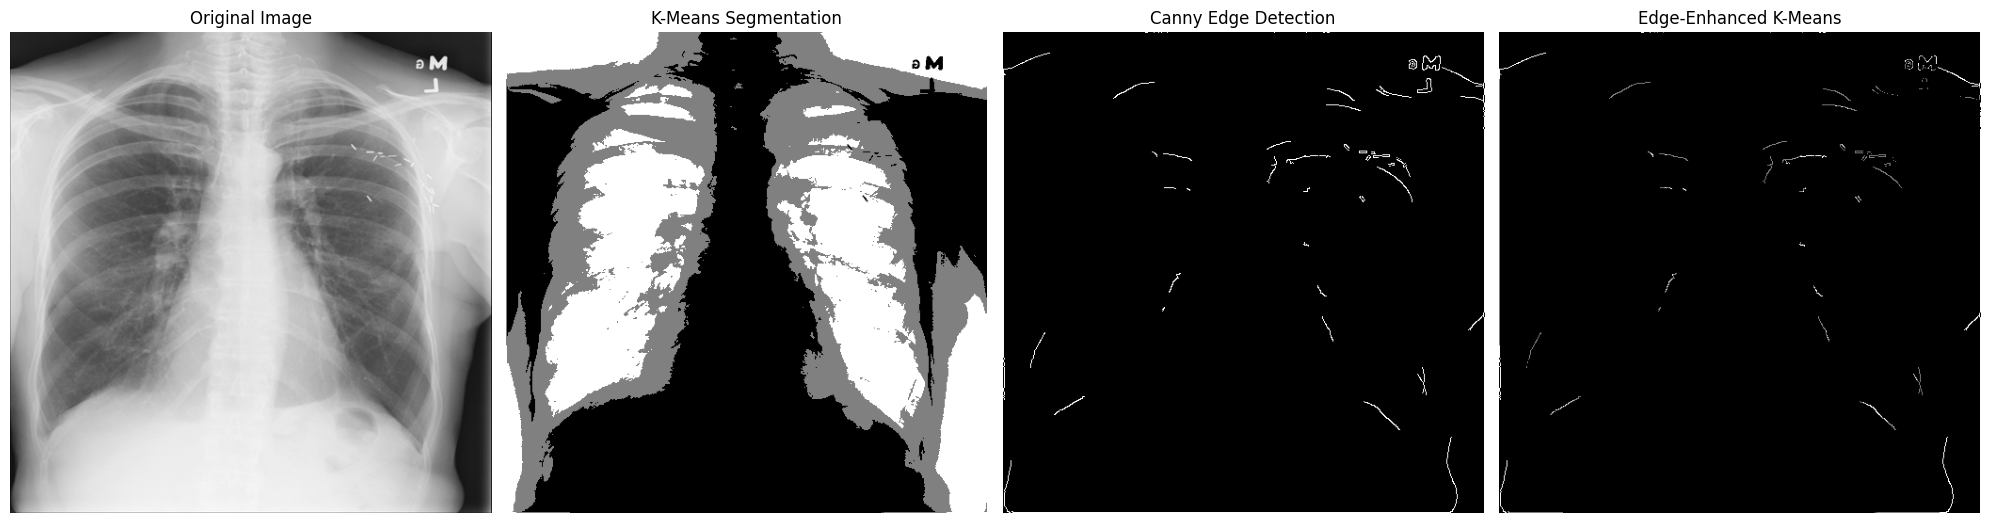

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_advanced_segmentation(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # --- K-Means Segmentation ---
    reshaped_img = image_rgb.reshape((-1, 3)).astype(np.float32)
    k = 3  # Number of clusters
    _, labels, _ = cv2.kmeans(reshaped_img, k, None, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0), 10, cv2.KMEANS_RANDOM_CENTERS)
    kmeans_result = labels.reshape(image_rgb.shape[:2])

    # Normalize kmeans_result to [0, 255] for compatibility with edge detection
    kmeans_result = cv2.normalize(kmeans_result, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # --- Canny Edge Detection for refinement ---
    edges = cv2.Canny(image_rgb, 100, 200)

    # Ensure both kmeans_result and edges are the same size
    if edges.shape != kmeans_result.shape:
        edges = cv2.resize(edges, (kmeans_result.shape[1], kmeans_result.shape[0]))

    # Ensure both arrays are the same type
    edges = edges.astype(np.uint8)

    # Combine K-Means with Edge Detection (Edge-enhanced K-Means)
    edge_enhanced_kmeans = cv2.bitwise_and(kmeans_result, edges)

    return image_rgb, kmeans_result, edges, edge_enhanced_kmeans

# Display results
fig, axs = plt.subplots(1, 4, figsize=(20, 10))

image_path = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal/Normal-1005.png'  # Update this to your image path
original_image, kmeans_result, edges, edge_enhanced_kmeans = apply_advanced_segmentation(image_path)

axs[0].imshow(original_image)
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(kmeans_result, cmap='gray')
axs[1].set_title("K-Means Segmentation")
axs[1].axis("off")

axs[2].imshow(edges, cmap='gray')
axs[2].set_title("Canny Edge Detection")
axs[2].axis("off")

axs[3].imshow(edge_enhanced_kmeans, cmap='gray')
axs[3].set_title("Edge-Enhanced K-Means")
axs[3].axis("off")

plt.tight_layout()
plt.show()
